In [1]:
import os 
import pandas as pd
import numpy as np

from IPython.core.display import display

import seaborn as sns
import matplotlib.pyplot as plt

import cufflinks as cf

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
import plotly.offline as offline
import plotly.tools as tls

import nltk as nltk
from nltk import bigrams 
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import scattertext as st
import spacy
nlp = spacy.load('en')

import textblob
from textblob import Word
from textblob import TextBlob

#from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import emoji
import regex

init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
def avgword(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

In [3]:
print("Current Working Directory " , os.getcwd())

Current Working Directory  C:\Users\Mikayel\Desktop\Python\ies_gplay_scraper


Now, we will load all the data we have scraped. We have dataframes of 3 columns. We have the amount of the **support** the comment received (net of the likes and dislikes to a comment), the actual contents of the **comment** and the final **rating** to the app given by the users (on a scale from 1 to 5; 5 being the highest).

In [4]:
files = [i for i in os.listdir('data') if 'reviews' in i]

# preparation of renaming files
nicks = ['fb', 'snap', 'whatsapp', 'musicaly']
renamer = [[val, nicks[i]] for i,val in enumerate(files)]

# batch loading

paths = ['data/'+i for i in files]
load = [pd.read_csv(i) for i in paths if 'reviews' in i]

# additing the file definition
load = [val.assign(app = renamer[i][1]) for i, val in enumerate(load)]

# concat into a DataFrame
dt = pd.concat(load)
dt.head()


fb = dt.query('app == "fb"')
snap = dt.query('app == "snap"')
musicaly = dt.query('app == "musicaly"')
whatsapp = dt.query('app == "whatsapp"')

### Datasets at a glance

In [5]:
print("For Facebook, there are {} observations and {} features in this dataset.".format(dt.query('app == "fb"').shape[0],dt.query('app == "fb"').shape[1]))
print("For Snapchat, there are {} observations and {} features in this dataset.".format(dt.query('app == "snap"').shape[0],dt.query('app == "snap"').shape[1]))
print("For Musicaly, there are {} observations and {} features in this dataset.".format(dt.query('app == "musicaly"').shape[0],dt.query('app == "musicaly"').shape[1]))
print("For Whatsapp, there are {} observations and {} features in this dataset.\n".format(dt.query('app == "whatsapp"').shape[0],dt.query('app == "whatsapp"').shape[1]))


For Facebook, there are 14080 observations and 4 features in this dataset.
For Snapchat, there are 11800 observations and 4 features in this dataset.
For Musicaly, there are 10600 observations and 4 features in this dataset.
For Whatsapp, there are 10280 observations and 4 features in this dataset.



In [6]:
display(
    "Total ratings",
    dt.describe(),
    "Facebook ratings",
    dt.query('app == "fb"').describe()
)

'Total ratings'

,rating,support
count,46760.000000,46760.000000
mean,2.990056,60.967387
std,1.655118,1062.156823
min,1.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,5.000000,3.000000
max,5.000000,111550.000000


'Facebook ratings'

,rating,support
count,14080.000000,14080.000000
mean,2.586435,48.622585
std,1.599480,559.188882
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,4.000000,3.000000
max,5.000000,25210.000000


The mean rating for the Facebook sample is 2.58, below of total app average of 2.98.

In [8]:
fb.loc[fb['support'] == fb.support.max()]

,review,rating,support,app
8,The app worked mostly well before the previous...,2,25210,fb


The highest support among Facebook reviewswas received by a complaint that had a 2-star rating, mentioning such problems like video or chat bubble crashes.

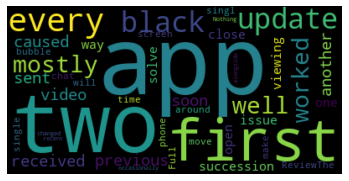

In [7]:
text = fb.review[8]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [10]:
#created a dummy variable, that equals unity if the review is positively rated (higher than 3)
dt['Positively_Rated'] = np.where(dt['rating']>3, 1, 0)

# add average word length as a variable
dt['word_count'] = dt['review'].apply(lambda x: len(str(x).split(" ")))
dt['char_count'] = dt['review'].str.len() ## this also includes spaces
dt['avgword'] = dt['review'].apply(lambda x: avgword(x))

#stopwords
stop = stopwords.words('english')
dt['stopwords'] = dt['review'].apply(lambda x: len([x for x in x.split() if x in stop]))

# number of numerics and uppercase words
dt['numerics'] = dt['review'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
dt['upper'] = dt['review'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
dt[['review','numerics','upper']].head()

#remove uppercase and punctuation
dt['review'] = dt['review'].apply(lambda x: " ".join(x.lower() for x in x.split())).str.replace('[^\w\s]','')

#remove stopwords
dt['review'] = dt['review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
dt['polarity'] = dt['review'].map(lambda text: TextBlob(text).sentiment.polarity)

dt.head()

,review,rating,support,app,Positively_Rated,word_count,char_count,avgword,stopwords,numerics,upper,polarity
0,messenger working reason getting message reque...,3,18560,fb,0,139,768,4.532374,63,0,7,0.250000
1,really like using app unfortunately keeps taki...,5,8673,fb,1,126,699,4.555556,42,0,3,-0.032727
2,notifications stuck 13 new messages cant find ...,1,1447,fb,0,108,660,5.120370,32,2,4,0.138384
3,love messenger far convenient messaging app kn...,4,11899,fb,1,140,748,4.350000,54,0,8,0.323993
4,sort aggravated abundance notifications receiv...,5,14593,fb,1,138,812,4.891304,61,0,6,0.138462


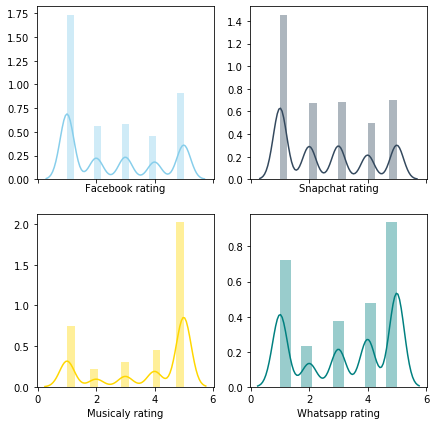

In [9]:
f, axes = plt.subplots(2,2 , figsize=(7, 7), sharex=True)

_ = sns.distplot(fb["rating"] , color="skyblue", ax=axes[0, 0], axlabel ="Facebook rating")
_ = sns.distplot( snap["rating"] , color="#34495e", ax=axes[0, 1],axlabel ="Snapchat rating")
_ = sns.distplot( musicaly["rating"] , color="gold", ax=axes[1, 0],axlabel ="Musicaly rating")
_ = sns.distplot( whatsapp["rating"] , color="teal", ax=axes[1, 1],axlabel ="Whatsapp rating")

Whilst Snapchat and Facebook have more negative 1-star reviews than positive (Facebook has the highest amount of 1-star reviews - 5752), Musicaly/TikTok seems to be very favourably rated by its users, with the highest amount of favourable 5 stars, 5725.

In [11]:
dt.groupby(['app', 'rating']).count()

review  support  Positively_Rated  word_count  char_count  \
app      rating                                                              
fb       1         5752     5752              5752        5752        5752   
         2         1858     1858              1858        1858        1858   
         3         1942     1942              1942        1942        1942   
         4         1517     1517              1517        1517        1517   
         5         3011     3011              3011        3011        3011   
musicaly 1         2121     2121              2121        2121        2121   
         2          627      627               627         627         627   
         3          857      857               857         857         857   
         4         1270     1270              1270        1270        1270   
         5         5725     5725              5725        5725        5725   
snap     1         4296     4296              4296        4296        4296   
         2         1979     1979              1979        1979        1979   
         3         2009     2009              2009        2009        2009   
         4         1458     1458              1458        1458        1458   
         5         2058     2058              2058        2058        2058   
whatsapp 1         2710     2710              2710        2710        2710   
         2          875      875               875         875         875   
         3         1407     1407              1407        1407        1407   
         4         1777     1777              1777        1777        1777   
         5         3511     3511              3511        3511        3511   

                 avgword  stopwords  numerics  upper  polarity  
app      rating                                                 
fb       1          5752       5752      5752   5752      5752  
         2          1858       1858      1858   1858      1858  
         3          1942       1942      1942   1942      1942  
         4          1517       1517      1517   1517      1517  
         5          3011       3011      3011   3011      3011  
musicaly 1          2121       2121      2121   2121      2121  
         2           627        627       627    627       627  
         3           857        857       857    857       857  
         4          1270       1270      1270   1270      1270  
         5          5725       5725      5725   5725      5725  
snap     1          4296       4296      4296   4296      4296  
         2          1979       1979      1979   1979      1979  
         3          2009       2009      2009   2009      2009  
         4          1458       1458      1458   1458      1458  
         5          2058       2058      2058   2058      2058  
whatsapp 1          2710       2710      2710   2710      2710  
         2           875        875       875    875       875  
         3          1407       1407      1407   1407      1407  
         4          1777       1777      1777   1777      1777  
         5          3511       3511      3511   3511      3511

To build the classification model, we get rid of the neutral reviews, which are generally regard as 3 stars.

In [ ]:
#created a dummy variable, that equals unity if the review is positively rated (higher than 3)
fb['Positively_Rated'] = np.where(fb['rating']>3, 1, 0)
fb.head(15)

,review,rating,support,app,Positively_Rated
0,"Messenger is NOT working! For some reason, I a...",3,18560,fb,0
1,"I really like using this App, But unfortunatel...",5,8673,fb,1
2,"My notifications are now stuck on ""13 new mess...",1,1447,fb,0
3,I love messenger. It's by far the most conveni...,4,11899,fb,1
4,I was sort of aggravated by the abundance of n...,5,14593,fb,1
5,"Apparently, i've been using messenger for year...",2,4489,fb,0
6,This app deviates more and more from its core ...,1,772,fb,0
7,"With the last update, you can't mute the sound...",4,1475,fb,1
8,The app worked mostly well before the previous...,2,25210,fb,0
9,it's good. but today it is not working well......,1,2542,fb,0


In [ ]:
fb[['Positively_Rated']].describe()

,Positively_Rated
count,14080.000000
mean,0.321591
std,0.467104
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Out of 14080 reviews in our sample, only 37.3% are positive.

In [ ]:
pd.crosstab(index = fb['Positively_Rated'], columns="Total count")

col_0,Total count
Positively_Rated,
0,9552
1,4528


In [ ]:
fb['word_count'] = fb['review'].apply(lambda x: len(str(x).split(" ")))
fb['char_count'] = fb['review'].str.len() ## this also includes spaces

fb.head(10)

,review,rating,support,app,Positively_Rated,numerics,upper,stopwords,avgword,word_count,char_count
0,"Messenger is NOT working! For some reason, I a...",3,18560,fb,0,0,7,63,4.532374,139,768
1,"I really like using this App, But unfortunatel...",5,8673,fb,1,0,3,42,4.555556,126,699
2,"My notifications are now stuck on ""13 new mess...",1,1447,fb,0,2,4,32,5.120370,108,660
3,I love messenger. It's by far the most conveni...,4,11899,fb,1,0,8,54,4.350000,140,748
4,I was sort of aggravated by the abundance of n...,5,14593,fb,1,0,6,61,4.891304,138,812
5,"Apparently, i've been using messenger for year...",2,4489,fb,0,0,2,69,4.203947,152,790
6,This app deviates more and more from its core ...,1,772,fb,0,0,2,53,4.671756,131,742
7,"With the last update, you can't mute the sound...",4,1475,fb,1,0,2,44,4.859504,121,708
8,The app worked mostly well before the previous...,2,25210,fb,0,0,3,60,4.284722,144,760
9,it's good. but today it is not working well......,1,2542,fb,0,0,2,78,4.370861,151,810


In [ ]:
# add average word length as a variable
fb['avgword'] = fb['review'].apply(lambda x: avgword(x))

Let's also calculate the amount of stopwords, numbers and special characters in the review

In [ ]:
#stopwords
fb['stopwords'] = fb['review'].apply(lambda x: len([x for x in x.split() if x in stop]))
fb.head()

,review,rating,support,app,Positively_Rated,numerics,upper,stopwords
0,"Messenger is NOT working! For some reason, I a...",3,18560,fb,0,0,7,63
1,"I really like using this App, But unfortunatel...",5,8673,fb,1,0,3,42
2,"My notifications are now stuck on ""13 new mess...",1,1447,fb,0,2,4,32
3,I love messenger. It's by far the most conveni...,4,11899,fb,1,0,8,54
4,I was sort of aggravated by the abundance of n...,5,14593,fb,1,0,6,61


In [ ]:
# number of numerics and uppercase words
fb['numerics'] = fb['review'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
fb['upper'] = fb['review'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
fb[['review','numerics','upper']].head()


,review,numerics,upper
0,"Messenger is NOT working! For some reason, I a...",0,7
1,"I really like using this App, But unfortunatel...",0,3
2,"My notifications are now stuck on ""13 new mess...",2,4
3,I love messenger. It's by far the most conveni...,0,8
4,I was sort of aggravated by the abundance of n...,0,6


Now, let's prepare the data for text mining and further analysis by pre-processing

In [ ]:
#remove uppercase
fb['review'] = fb['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#remove punctuation
fb['review'] = fb['review'].str.replace('[^\w\s]','')

#remove stopwords
fb['review'] = fb['review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
fb.head()

,review,rating,support,app,Positively_Rated,numerics,upper,stopwords,avgword,word_count,char_count
0,messenger working reason getting message reque...,3,18560,fb,0,0,7,63,4.532374,139,768
1,really like using app unfortunately keeps taki...,5,8673,fb,1,0,3,42,4.555556,126,699
2,notifications stuck 13 new messages cant find ...,1,1447,fb,0,2,4,32,5.120370,108,660
3,love messenger far convenient messaging app kn...,4,11899,fb,1,0,8,54,4.350000,140,748
4,sort aggravated abundance notifications receiv...,5,14593,fb,1,0,6,61,4.891304,138,812


In [ ]:
avg_word_count = dt['word_count'].mean()
avg_word_count_snap=dt[dt['app']=="snap"]["word_count"].mean()
avg_word_count_fb=dt[dt['app']=="fb"]["word_count"].mean()
avg_word_count_musicaly=dt[dt['app']=="musicaly"]["word_count"].mean()
avg_word_count_whatsapp=dt[dt['app']=="whatsapp"]["word_count"].mean()

pd.DataFrame([avg_word_count_fb, avg_word_count_snap, avg_word_count_musicaly, avg_word_count_whatsapp,avg_word_count], index = ['Fb', 'Snap','Musicaly','Whatsapp','Total'], columns = ['average']) 

,average
Fb,34.263068
Snap,45.189492
Musicaly,35.029623
Whatsapp,41.338716
Total,38.749701


Interestingly, Snapchat's reviewers seem to be the wordiest, with the average word count of the review being the largest - 45.18.

In [ ]:
dt.loc[:,['polarity', 'word_count']].head()

,polarity,word_count
0,0.250000,139
1,-0.032727,126
2,0.138384,108
3,0.323993,140
4,0.138462,138


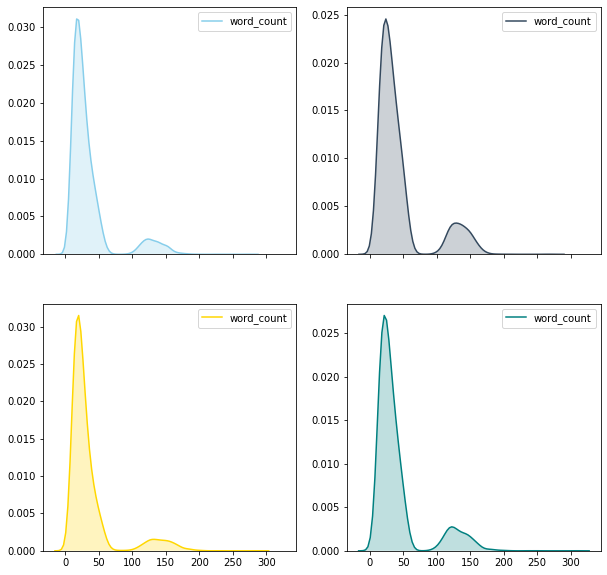

In [ ]:
avg_word_count =dt['word_count'].mean()

f, axes = plt.subplots(2,2 , figsize=(10, 10), sharex=True)
_ = sns.kdeplot(dt[dt['app']=="fb"]["word_count"] , color="skyblue", ax=axes[0, 0],shade=True)
_ = sns.kdeplot(dt[dt['app']=="snap"]["word_count"] , color="#34495e", ax=axes[0, 1],shade=True)                #,ax ="Snapchat rating")
_ = sns.kdeplot(dt[dt['app']=="musicaly"]["word_count"] , color="gold", ax=axes[1, 0],shade=True)               #,ax ="Musicaly rating")
_ = sns.kdeplot(dt[dt['app']=="whatsapp"]["word_count"] , color="teal", ax=axes[1, 1],shade=True)               #,ax ="Whatsapp rating")

It would also be interesting to see, whether or not the little bump in the amount of word count (between 100 and 150 words) is connected to a higher negative sentiment (one would expect disappointed users to have higher commitment to writing the review)

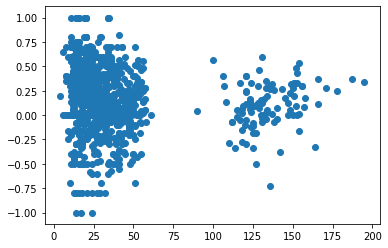

In [ ]:
samp = dt.iloc[np.random.randint(1, 46760, 1000)]

plt.scatter(samp.word_count, samp.polarity)

However, this seems not to be the case - since the dispersion of the sentiment is seemingly random.

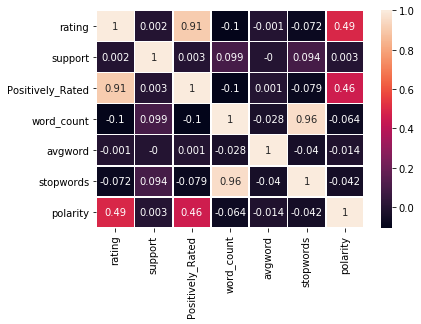

In [ ]:
_ = sns.heatmap(dt[['rating','support','Positively_Rated','word_count','avgword','stopwords','polarity']].corr().round(3), annot=True, linewidth=0.75)

In [ ]:
# let's also lemmatize the reviews
fb['review'] = fb['review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
fb[['review']].head()

,review
0,messenger working reason getting message reque...
1,really like using app unfortunately keep takin...
2,notification stuck 13 new message cant find an...
3,love messenger far convenient messaging app kn...
4,sort aggravated abundance notification receive...


In [ ]:
freq = pd.Series(' '.join(fb['review']).split()).value_counts()[:15]
freq

app          6701
messenger    4687
update       3206
cant         2958
messages     2163
like         2137
please       2111
dont         2015
fix          1856
phone        1733
use          1681
get          1671
message      1634
chat         1611
video        1603
dtype: int64

We then use  TextBlob to calculate sentiment polarity (ranging betweeen -1 and 1; where 1 means positive sentiment and -1 means a negative sentiment)


In [ ]:
fb['polarity'] = fb['review'].map(lambda text: TextBlob(text).sentiment.polarity)
fb.head()

,review,rating,support,app,Positively_Rated,numerics,upper,stopwords,avgword,word_count,char_count,polarity
0,messenger working reason getting message reque...,3,18560,fb,0,0,7,63,4.532374,139,768,0.250000
1,really like using app unfortunately keep takin...,5,8673,fb,1,0,3,42,4.555556,126,699,-0.032727
2,notification stuck 13 new message cant find an...,1,1447,fb,0,2,4,32,5.120370,108,660,0.193182
3,love messenger far convenient messaging app kn...,4,11899,fb,1,0,8,54,4.350000,140,748,0.323993
4,sort aggravated abundance notification receive...,5,14593,fb,1,0,6,61,4.891304,138,812,0.138462


#### Tokenization

Sentence tokenizer splits paragraph text into sentences, whilst 

In [ ]:
# join all rows into one text
text=fb["review"].str.cat(sep=' ')
tokenized_text=sent_tokenize(text)
#print(tokenized_text)

tokenized_word=word_tokenize(text)
#print(tokenized_word)

fdist = FreqDist(tokenized_word)
#print(fdist)
#fdist.most_common(15)



### Visualizations

In [ ]:
# Top 30 most frequent words

fdist.plot(30,cumulative=False)
plt.show()

In [ ]:
# join all rows into one text
text=dt["review"].str.cat(sep=' ')
tokenized_text=sent_tokenize(text)

fdistall = FreqDist(tokenized_word)
fdistall.plot(30,cumulative=False)
plt.show()


In [ ]:
topics = ['app', 'messenger', 'update','message','cant']

for topic in topics:
    print(topic,'more :', ' , '.join([ word.lower() for word, count in fdist.most_common(5)]))
    print(topic,'less :', ' , '.join([ word.lower() for word, count in fdist.most_common()[-5:]]))

In [ ]:
dt['parsed'] = dt.review.apply(nlp)

In [ ]:
dt.head()

In [ ]:
words = dt.query('app == "fb"').review.str.split(' ')
fb_top15 = words.apply(pd.Series).melt().dropna().groupby('value').size().sort_values(ascending = False).iloc[:15]
words = dt.query('app == "whatsapp"').review.str.split(' ')
what_top15 = words.apply(pd.Series).melt().dropna().groupby('value').size().sort_values(ascending = False).iloc[:15]

In [ ]:
pd.DataFrame((fb_top15, what_top15), index = ['fb','whatsapp']).T.dropna()